# Class 25: Unsupervised learning

Plan for today:
- Linear regression
- Clustering


In [16]:
import YData

# YData.download.download_class_code(25)   # get class code    
# YData.download.download_class_code(25, TRUE) # get the code with the answers 



If you are using colabs, you should run the code below.

In [17]:
# !pip install https://github.com/emeyers/YData_package/tarball/master
# from google.colab import drive
# drive.mount('/content/drive')

In [18]:
import statistics
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from urllib.request import urlopen

import matplotlib.pyplot as plt
%matplotlib inline

# Suppress ConvergenceWarning - please ignore this code 
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


## 0. Linear regression review

In regression, we try to predict a quantitative variable y, from a set of features X. 

Let's explore this by predicting the body mass of penguins (in grams) from other quantitative features of a penguin (e.g., their bill and flipper sizes). 


In [19]:
penguins = sns.load_dataset("penguins")
penguins = penguins.dropna()
penguins = penguins.sample(frac = 1)
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
14,Adelie,Torgersen,34.6,21.1,198.0,4400.0,Male
326,Gentoo,Biscoe,41.7,14.7,210.0,4700.0,Female
114,Adelie,Biscoe,39.6,20.7,191.0,3900.0,Female
242,Gentoo,Biscoe,46.5,14.5,213.0,4400.0,Female
171,Chinstrap,Dream,49.2,18.2,195.0,4400.0,Male


In [20]:
# get the features and the labels

X_penguin_features = penguins[['bill_length_mm', 
                               'bill_depth_mm',
                               'flipper_length_mm']]

y_penguin = penguins['body_mass_g']


# also save the penguin species to use later
y_penguin_species = penguins['species']


Let's use scikit-learn to generate training and test data as we did previously for our KNN classifier. 

In [21]:
from sklearn.model_selection import train_test_split

# split data into a training and test set

X_train, X_test, y_train, y_test = train_test_split(X_penguin_features,  
                                                    y_penguin, 
                                                    random_state = 0)

print(X_train.shape)
print(X_test.shape)

X_train.head(5)


(249, 3)
(84, 3)


,bill_length_mm,bill_depth_mm,flipper_length_mm
211,45.6,19.4,194.0
262,45.3,13.7,210.0
297,51.1,16.3,220.0
66,35.5,16.2,195.0
121,37.7,19.8,198.0


We can now create a new linear regression model, fit it to data, and make predictions. The method names are again very similar to what we used for the KNN classifier (i.e., the `fit()` and predict()` methods). 

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# create a new linear regression moded
linear_model = LinearRegression()


# fit the model to our training data
linear_model.fit(X_train, y_train)


# make predictions of the penguins body weight on the test data
body_mass_predictions = linear_model.predict(X_test)

# Use scikit-learn's mean_squared_error() function to get the RMSE
np.sqrt(mean_squared_error(y_test, body_mass_predictions))


np.float64(401.4206534832508)

In [23]:
# using cross-validation
from sklearn.model_selection import cross_val_score

linear_model = LinearRegression()

scores = cross_val_score(linear_model, 
                         X_penguin_features,  
                         y_penguin, 
                         cv = 5, 
                         scoring='neg_mean_squared_error')

np.sqrt(np.mean(-1 * scores))

np.float64(395.03269948951606)

### Regression model equation

In linear regression, our predicted $\hat{y}$ values are given by the equation: $\hat{y} = b_0 + b_1 x_1 + ... + + b_k x_k$.

Let's fill out this equation for prediciting penguin body mass. 

To do this, let's start by extracting the intercept ($b_0$) and slope coefficients ($b_i's$) from our scikit-learn model.


In [24]:

# fit the linear regression model to our training data
linear_model.fit(X_train, y_train)

# get the intercept and slope coefficients
sklearn_intercept = linear_model.intercept_
sklearn_coefficients = linear_model.coef_

# print out the coefficient values
(sklearn_intercept, sklearn_coefficients)  


(np.float64(-6183.0307528092135),
 array([ 3.60829435, 11.46057239, 49.99278042]))

Given these coefficient values can you write our the regression equation for predicting penguin body mass? 


#### Answer

$\hat{y}_{mass} = -6680.13 + 0.5049 \cdot x_{bill-length} + 21.6384 \cdot x_{bill-depth} +  52.1411 \cdot x_{lipper-length}$



## 1. Inference on regression coefficients

We can also run inference procedures on our regression model using the statsmodel package. In particular, we can run hypothesis tests and create confidence intervals for our regression coefficents. 

When running a hypothesis test, our hypotheses are:

$H_0: \beta_i = 0$  
$H_A: \beta_i \ne 0$


In [25]:
# Hypothesis test on regression coeffients - which coefficients are statistically significantly different from zero? 
# (and confidence interval)

import statsmodels.api as sm

# add a constant value of 1 to our data
X_train_with_constant = sm.add_constant(X_train) 

# fit the linear regression model using the OLS function
sm_linear_model = sm.OLS(y_train, X_train_with_constant).fit()

# get information on the regression coefficients found
print(sm_linear_model.summary())


                            OLS Regression Results                            
Dep. Variable:            body_mass_g   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     258.9
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           1.19e-75
Time:                        21:41:26   Log-Likelihood:                -1837.2
No. Observations:                 249   AIC:                             3682.
Df Residuals:                     245   BIC:                             3696.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -6183.0308    651.32

## 2. Unsupervised learning: clustering

We can do k-means clustering in scikit-learn using the `KMeans()` object.


In [26]:
from sklearn.cluster import KMeans

# fit k-means with 3 clusters 

kmeans = KMeans(n_clusters=3)
kmeans.fit(X_penguin_features)

,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


In [27]:
# see which cluster each point belongs to 

predicted_labels = kmeans.predict(X_penguin_features)
predicted_labels

array([2, 1, 0, 1, 2, 0, 2, 0, 1, 2, 1, 1, 1, 2, 0, 0, 1, 0, 2, 2, 1, 1,
       2, 1, 2, 2, 1, 1, 1, 1, 2, 0, 1, 2, 1, 0, 0, 0, 1, 1, 0, 2, 0, 0,
       1, 1, 0, 1, 2, 1, 2, 2, 0, 2, 2, 1, 2, 2, 2, 0, 0, 1, 1, 0, 1, 0,
       2, 2, 0, 0, 1, 1, 0, 0, 1, 2, 0, 2, 0, 0, 1, 2, 0, 2, 0, 1, 0, 2,
       1, 2, 1, 0, 2, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 2, 0, 2, 1, 1,
       2, 0, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 0, 0, 1, 1, 0, 1, 2, 2, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 2, 1, 0, 1, 0, 0, 2, 1, 1, 0,
       1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 0, 1, 1, 2, 0, 1, 0, 0, 1, 2, 0,
       1, 0, 2, 0, 1, 2, 2, 2, 1, 0, 2, 1, 1, 0, 0, 2, 0, 1, 0, 0, 0, 1,
       1, 1, 2, 0, 0, 2, 0, 1, 1, 1, 1, 2, 0, 1, 1, 1, 0, 2, 0, 0, 1, 1,
       1, 1, 2, 1, 0, 0, 2, 0, 0, 1, 1, 2, 1, 1, 0, 0, 0, 0, 2, 0, 1, 0,
       0, 1, 2, 1, 1, 1, 1, 0, 2, 0, 0, 2, 1, 1, 2, 0, 1, 1, 1, 1, 2, 0,
       2, 1, 0, 2, 2, 1, 2, 0, 2, 0, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 0, 1,
       2, 1, 0, 0, 1, 2, 0, 0, 1, 0, 1, 1, 2, 0, 1,

In [28]:
# look at a matrix of which penguin types end up in which cluster 

ct = pd.crosstab(predicted_labels, y_penguin_species)
print(ct)

species  Adelie  Chinstrap  Gentoo
row_0                             
0           106          9       0
1             2          5     118
2            38         54       1


In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# do clustering with feature normalization 
scaler = StandardScaler()
pipeline = make_pipeline(scaler, kmeans)

pipeline.fit(X_penguin_features)

,steps,"[('standardscaler', ...), ('kmeans', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,300


In [30]:
# see which cluster each (normalized) point belongs to

predicted_labels2 = pipeline.predict(X_penguin_features)

predicted_labels2


array([0, 1, 0, 1, 2, 0, 0, 0, 1, 2, 1, 1, 1, 2, 0, 0, 1, 0, 0, 0, 1, 1,
       2, 1, 2, 2, 2, 1, 1, 1, 2, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 2, 0, 1, 2, 0, 2, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 1, 0, 0,
       1, 2, 1, 2, 2, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 1, 1, 2, 0, 0, 1, 1,
       2, 0, 0, 1, 1, 1, 2, 1, 1, 2, 1, 0, 0, 0, 1, 1, 0, 1, 2, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 2, 0, 0, 1, 1, 0,
       1, 2, 0, 1, 1, 1, 2, 1, 1, 2, 2, 0, 1, 1, 2, 0, 1, 0, 0, 2, 2, 0,
       1, 0, 2, 0, 1, 0, 2, 2, 1, 0, 2, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 1,
       1, 1, 2, 0, 0, 2, 0, 1, 1, 0, 1, 2, 0, 1, 1, 1, 0, 2, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 2, 0, 0, 2, 1, 2, 1, 1, 0, 0, 0, 0, 2, 0, 1, 0,
       0, 1, 2, 1, 2, 1, 1, 0, 0, 0, 0, 2, 1, 1, 2, 0, 1, 1, 1, 1, 2, 0,
       2, 1, 0, 2, 2, 1, 2, 2, 0, 0, 1, 1, 0, 2, 2, 2, 2, 2, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 2, 0, 0, 1, 0, 1, 1, 2, 0, 1,

In [31]:
# look at a matrix of which penguin types end up in which cluster 

ct_new = pd.crosstab(predicted_labels2, y_penguin_species)

print(ct_new)

species  Adelie  Chinstrap  Gentoo
row_0                             
0           141          5       0
1             0          0     119
2             5         63       0


### 2b. Unsupervised learning: Hierarchical clustering


In [17]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

#  Ward's method adds points to a cluster that minimizes the sum of squared differences within all clusters
clusters = hierarchy.linkage(X_penguin_features, method="ward")   


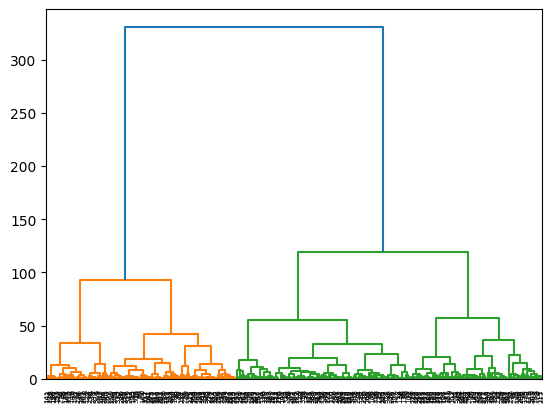

In [18]:
# display a dendrogram
dendrogram = hierarchy.dendrogram(clusters)

In [19]:
# cluster points into 3 clusters 
clustering_model = AgglomerativeClustering(n_clusters=3, linkage="ward")
clustering_model.fit(X_penguin_features)

# get the predicted cluster for each point
labels = clustering_model.labels_

labels

array([0, 2, 0, 1, 1, 0, 2, 0, 0, 1, 0, 0, 1, 0, 0, 0, 2, 2, 2, 0, 2, 0,
       2, 0, 2, 1, 1, 1, 2, 2, 2, 1, 1, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0, 2,
       2, 1, 2, 2, 0, 0, 2, 2, 0, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 2, 2, 0, 0, 1, 2, 1, 0, 0, 0,
       2, 2, 2, 1, 2, 0, 0, 0, 2, 0, 2, 2, 1, 2, 2, 0, 2, 2, 0, 2, 0, 0,
       2, 1, 0, 2, 2, 0, 2, 1, 2, 1, 2, 1, 0, 1, 2, 0, 0, 2, 1, 2, 1, 2,
       2, 2, 2, 2, 2, 1, 0, 0, 2, 0, 0, 2, 2, 1, 0, 2, 2, 0, 1, 1, 1, 2,
       1, 2, 1, 0, 2, 0, 1, 0, 2, 0, 0, 0, 2, 0, 0, 1, 1, 2, 0, 2, 0, 1,
       1, 2, 2, 2, 0, 0, 1, 2, 1, 0, 1, 2, 1, 1, 1, 0, 0, 0, 2, 0, 0, 1,
       0, 2, 2, 0, 0, 0, 0, 2, 2, 1, 2, 0, 2, 1, 1, 1, 1, 1, 2, 0, 0, 2,
       2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2,
       2, 0, 0, 1, 2, 2, 0, 1, 2, 2, 1, 2, 0, 1, 0, 0, 1, 0, 0, 2, 0, 1,
       1, 1, 2, 2, 2, 2, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 2, 2, 1, 0,
       1, 2, 1, 0, 2, 0, 2, 0, 1, 2, 1, 1, 1, 1, 0,

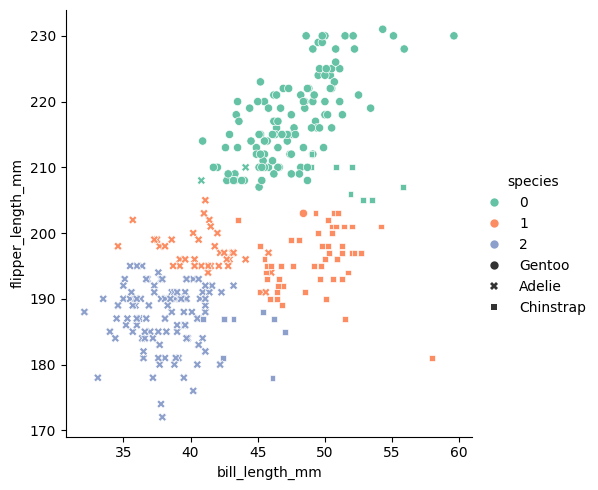

In [20]:
# visualize how well the clustering matches the penguin species

sns.relplot(X_penguin_features, 
            x='bill_length_mm', 
            y='flipper_length_mm', 
            hue=labels, 
            style = y_penguin_species,
            palette="Set2");


## 3. Chatbots 

Large language models (LLMs) are taking over the world. I, for one, welcome our new robot [overlords](https://www.youtube.com/watch?v=8lcUHQYhPTE).

Let's explore how we can use a model from HuggingFace to create a chatbot.

To do this we need to install some additional packages. I recommend cloning your Jupyter environment, and then adding these packages to the new environment.


In [21]:
# Modified from code created by Giuliano Formisano
# Updated to work with new version of hugging face packages

from transformers import pipeline, BlenderbotTokenizer, BlenderbotForConditionalGeneration

model_name = "facebook/blenderbot-400M-distill"

# Option A: Using text2text-generation pipeline (single-turn):
chatbot = pipeline("text2text-generation", model=model_name, tokenizer=model_name, device = "cpu")

# This uses "mps" by default on my mac which should be faster but there appears to be a bug in the code
#chatbot = pipeline("text2text-generation", model=model_name, tokenizer=model_name)


user_input = "Hi! What can you do?"
response = chatbot(user_input, max_new_tokens=50)

print(f"User:  {user_input}")
print(f"Bot:   {response[0]['generated_text']}")



2025-12-01 11:48:48.264157: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-01 11:48:48.577396: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-01 11:48:53.117102: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Device set to use cp

User:  Hi! What can you do?
Bot:    I can't do anything. I am so sad. I feel like I am going to die.


### Loop for an interaction User-Chatbot

In [ ]:
# Loop of interaction user-chatbot
while True:
  user_input = input("You: ") # add prompt in the appearing box below
  if user_input.lower() == "quit": # write "quit" to interrupt
    break
  response = chatbot(user_input) # this is a bit slow
  print(f"Chatbot: {response[0]['generated_text']}")

### Hugging Face data sets

In [25]:
# Hugging Face also has a number of large/interesting data sets
# (some of them controversial, and of course, one should be cautious of the veracity of all data sets)



# Load a data set 

from datasets import load_dataset

#emails = load_dataset("tensonaut/EPSTEIN_FILES_20K", split="train")
emails = load_dataset("corbt/enron-emails", split="train")


# print type and shape
print(emails.shape)
print(type(emails))


# convert to a pandas data frame
emails_df = emails.to_pandas()

display(emails_df.head())


(517401, 9)
<class 'datasets.arrow_dataset.Dataset'>


,message_id,subject,from,to,cc,bcc,date,body,file_name
0,<18782981.1075855378110.JavaMail.evans@thyme>,,phillip.allen@enron.com,[tim.belden@enron.com],[],[],2001-05-14 23:39:00+00:00,Here is our forecast\n\n,allen-p/_sent_mail/1.
1,<15464986.1075855378456.JavaMail.evans@thyme>,Re:,phillip.allen@enron.com,[john.lavorato@enron.com],[],[],2001-05-04 20:51:00+00:00,Traveling to have a business meeting takes the...,allen-p/_sent_mail/10.
2,<24216240.1075855687451.JavaMail.evans@thyme>,Re: test,phillip.allen@enron.com,[leah.arsdall@enron.com],[],[],2000-10-18 10:00:00+00:00,test successful. way to go!!!,allen-p/_sent_mail/100.
3,<13505866.1075863688222.JavaMail.evans@thyme>,,phillip.allen@enron.com,[randall.gay@enron.com],[],[],2000-10-23 13:13:00+00:00,"Randy,\n\n Can you send me a schedule of the s...",allen-p/_sent_mail/1000.
4,<30922949.1075863688243.JavaMail.evans@thyme>,Re: Hello,phillip.allen@enron.com,[greg.piper@enron.com],[],[],2000-08-31 12:07:00+00:00,Let's shoot for Tuesday at 11:45.,allen-p/_sent_mail/1001.


In [26]:
# search for keywords
emails_containing = "summers" 

# rfind returns first index where word occurs
selected_emails = emails_df[(emails_df.body.str.lower().str.rfind(emails_containing) > 0)]
#selected_emails = emails_df[(emails_df.text.str.lower().str.rfind(emails_containing) > 0)]


print(selected_emails.shape)
display(selected_emails.head())

#print(selected_emails.iloc[0].text)

(814, 9)


,message_id,subject,from,to,cc,bcc,date,body,file_name
512,<19163786.1075855728582.JavaMail.evans@thyme>,California - Jan 13 meeting,phillip.allen@enron.com,[keith.holst@enron.com],[],[],2001-01-16 07:18:00+00:00,---------------------- Forwarded by Phillip K ...,allen-p/_sent_mail/564.
1136,<19332193.1075855699017.JavaMail.evans@thyme>,California - Jan 13 meeting,phillip.allen@enron.com,[keith.holst@enron.com],[],[],2001-01-16 07:18:00+00:00,---------------------- Forwarded by Phillip K ...,allen-p/all_documents/585.
1779,<31584452.1075855708139.JavaMail.evans@thyme>,California - Jan 13 meeting,phillip.allen@enron.com,[keith.holst@enron.com],[],[],2001-01-16 07:18:00+00:00,---------------------- Forwarded by Phillip K ...,allen-p/discussion_threads/395.
2926,<15436486.1075855718195.JavaMail.evans@thyme>,California - Jan 13 meeting,phillip.allen@enron.com,[keith.holst@enron.com],[],[],2001-01-16 07:18:00+00:00,---------------------- Forwarded by Phillip K ...,allen-p/sent/517.
5487,<30615416.1075861663787.JavaMail.evans@thyme>,"GREAT SAVINGS FROM Spec's Wines, Spirits & Fin...",specs@wineisit.com,[jarnold@ect.enron.com],[],[],2001-11-18 23:01:32+00:00,<head>\n<title>WineISIT.com - Member E-mail</t...,arnold-j/deleted_items/622.


In [27]:
%%capture

# You can run this code to covert this Jupyter notebook into a pdf
!quarto render class_25_answers.ipynb --cache-refresh --to pdf 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
